In [1]:
import os
import scipy.io

def read_mat_files(data_path):
    # List to hold all data
    all_data = []
    all_data_name = []
    # Iterate over each file in the directory
    for file in os.listdir(data_path):
        if file.endswith('.mat'):
            file_path = os.path.join(data_path, file)

            # Load the .mat file
            data = scipy.io.loadmat(file_path)

            # Append the data to the list
            all_data.append(data)
            all_data_name.append(file)

    return all_data, all_data_name

# Specify the data path
data_path = '../../weight_datas/weight_square_wave'

# Call the function to read data
mat_data, mat_data_name = read_mat_files(data_path)

In [2]:
import os
import scipy.io
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft

# machine learning parts
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

In [3]:
def seperation_signal(signal, fs, thre = 0.5, d_ratio = 0.5):
    distance_between_peaks = fs * d_ratio  # Expected distance between peaks in samples

    # Using the find_peaks function from scipy.signal to detect peaks
    peaks, _ = find_peaks(signal, distance=distance_between_peaks)

    highest_peak_value = np.max(signal[peaks])

    # Define the threshold as 1/3 of the highest peak value
    threshold_value = highest_peak_value * thre

    # Filter out peaks that are lower than the threshold
    filtered_peaks = peaks[signal[peaks] > threshold_value]

    return filtered_peaks


16
8
40
44
73
65
9
19
57


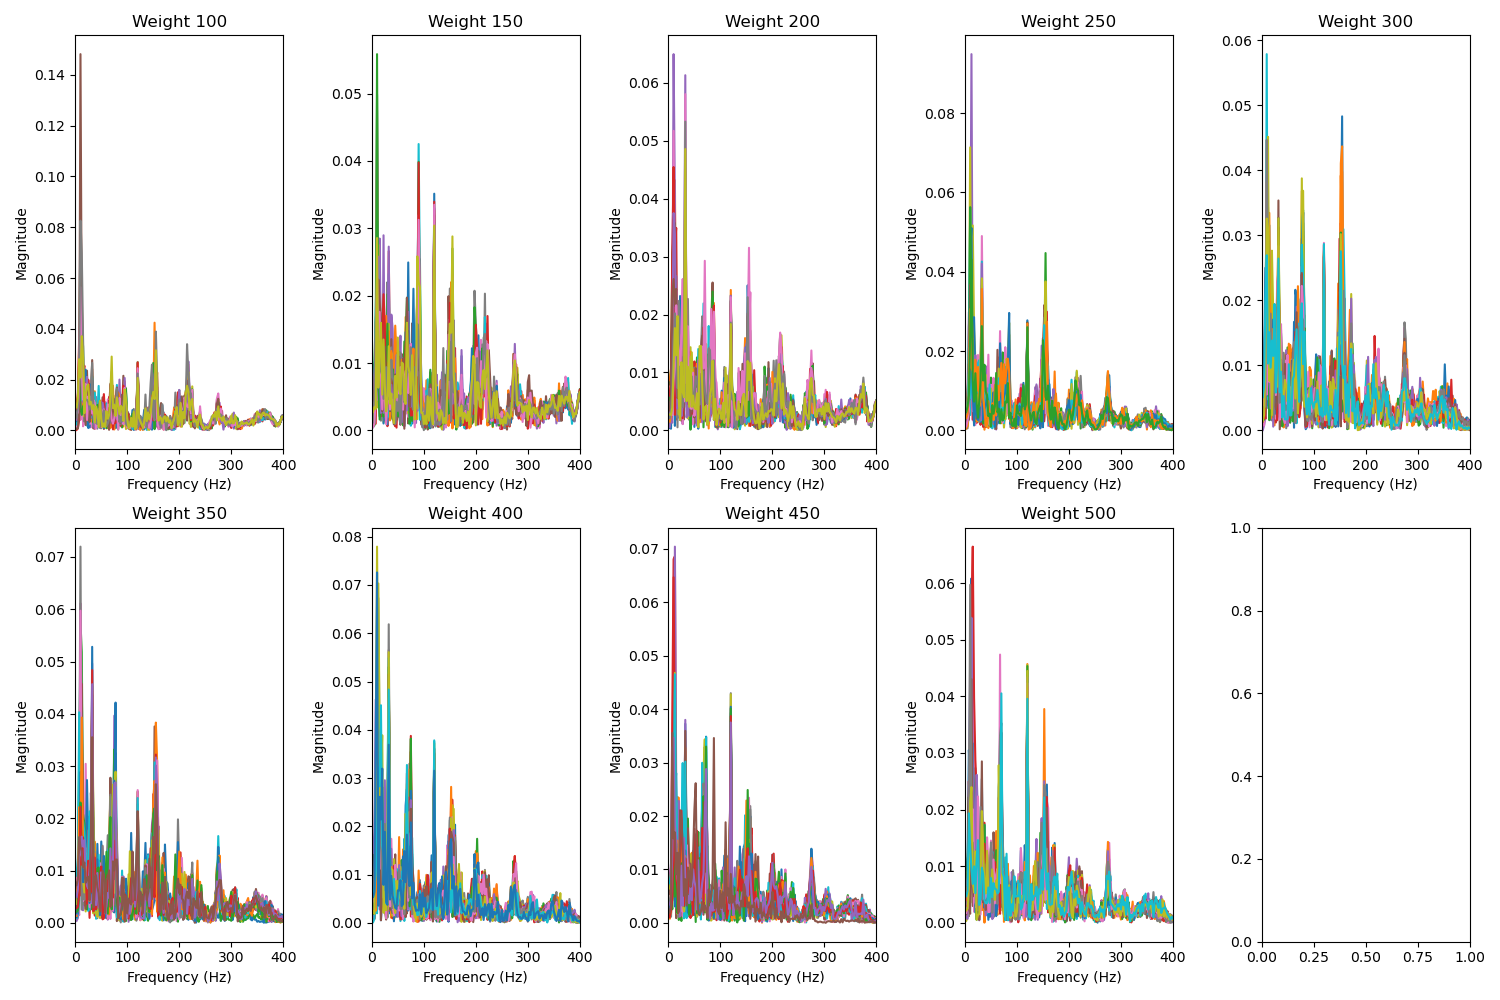

In [4]:
weights = [100, 150, 200, 250, 300, 350, 400, 450, 500]
loc = 5
fs = 25600
fig, axs = plt.subplots(2,5, figsize=(15, 10))
for j, w in enumerate(weights):
    file_name = str(w) + 'g_loc' + str(loc) + '.mat'
    idx = np.where(np.array(mat_data_name) == file_name)[0][0]
    print(idx)
    data = mat_data[idx]['data']
    time = np.arange(0, len(data)/fs, 1/fs)

    signal = data[:, 1] - 2.5
    filtered_peaks = seperation_signal(signal, fs)
    # Plotting the signal and the detected peaks
    # plt.figure(figsize=(14, 7))
    # plt.plot(time, signal, label='Signal')
    # plt.plot(time[filtered_peaks], signal[filtered_peaks], 'x', label='Detected Peaks')
    # plt.title(f'Signal with Detected Peaks with weight {w}')
    # plt.xlabel('Time (seconds)')
    # plt.ylabel('Amplitude')
    # plt.legend()
    # plt.show()

    time_window = 0.2  # 0.2 seconds on each side of the peak

    # Calculate the number of samples in the time window
    samples_window = int(time_window * fs)

    # FFT analysis on each segment
    fft_segments = []
    frequency_bins = np.fft.fftfreq(samples_window * 2, 1/fs)

    for peak in filtered_peaks:
        # Extract the segment around the peak
        start_index = int(max(peak - samples_window, 0))
        end_index = int(min(peak + samples_window, len(signal)))
        segment = signal[start_index:end_index]

        # Compute FFT of the segment
        segment_fft = fft(segment)

        # Normalize the FFT output
        segment_fft = np.abs(segment_fft) / len(segment_fft)

        # Store the FFT result
        fft_segments.append(segment_fft)

    # Plot all the FFT spectra within one figure
    ax = axs[j // 5, j % 5]
    for i, fft_segment in enumerate(fft_segments):
        ax.plot(frequency_bins[1:len(fft_segment)//2], fft_segment[1:len(fft_segment)//2], label=f'Segment {i+1}')
    ax.set_xlim([0, 400])
    ax.set_title(f'Weight {w}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
 
plt.tight_layout()
plt.show()

In [11]:
# Extract fft features and labels and use that for the regression model, use the first 160 elements as features
weights = [100, 150, 200, 250, 300, 350, 400, 450, 500]
loc = 5
fs = 25600
sensor_num = 2
fft_segments = []
weights_label = []
for j, w in enumerate(weights):
    file_name = str(w) + 'g_loc' + str(loc) + '.mat'
    idx = np.where(np.array(mat_data_name) == file_name)[0][0]
    print(idx)
    data = mat_data[idx]['data']
    time = np.arange(0, len(data)/fs, 1/fs)

    signal = data[:, sensor_num] - 2.5
    filtered_peaks = seperation_signal(signal, fs)
    time_window = 0.2  # 0.2 seconds on each side of the peak

    # Calculate the number of samples in the time window
    samples_window = int(time_window * fs)

    # FFT analysis on each segment
    
    frequency_bins = np.fft.fftfreq(samples_window * 2, 1/fs)

    for peak in filtered_peaks:
        # Extract the segment around the peak
        start_index = int(max(peak - samples_window, 0))
        end_index = int(min(peak + samples_window, len(signal)))
        segment = signal[start_index:end_index]

        # Compute FFT of the segment
        segment_fft = fft(segment)

        # Normalize the FFT output
        segment_fft = np.abs(segment_fft) / len(segment_fft)

        # Store the FFT result
        fft_segments.append(segment_fft[1:100])
        weights_label.append(w)


16
8
40
44
73
65
9
19
57


In [12]:
# For regression task
# Prepare the data
feats = np.array(fft_segments)
y = np.array(weights_label)
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size = 0.2, random_state = 42)
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 58.03385180121966


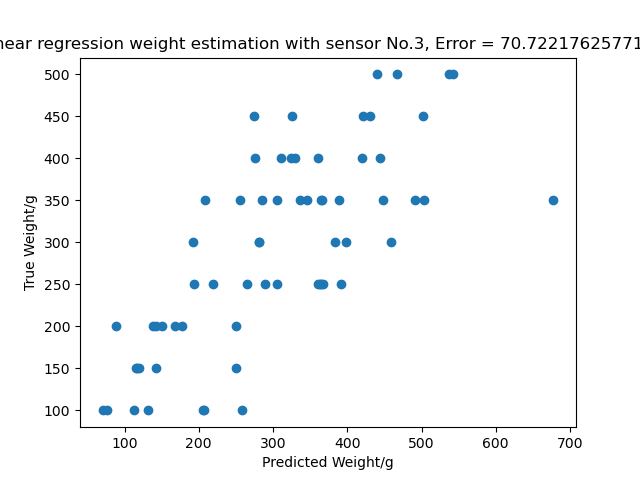

In [7]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.title(f"Linear regression weight estimation with sensor No.{sensor_num}, Error = {mae}")
plt.xlabel("Predicted Weight/g")
plt.ylabel("True Weight/g")
plt.show()

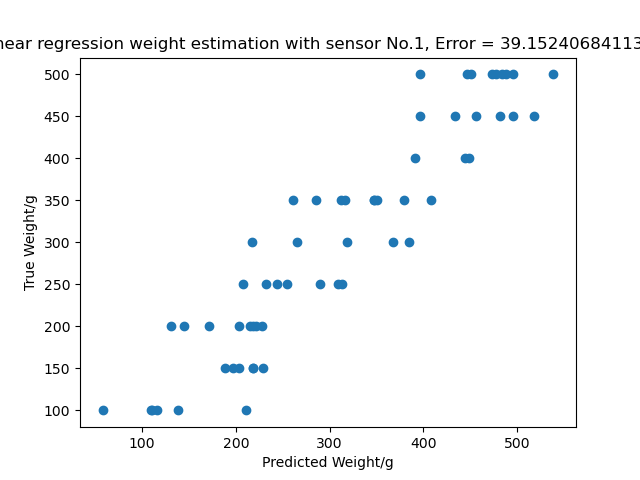

In [10]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.title(f"Linear regression weight estimation with sensor No.{sensor_num}, Error = {mae}")
plt.xlabel("Predicted Weight/g")
plt.ylabel("True Weight/g")
plt.show()

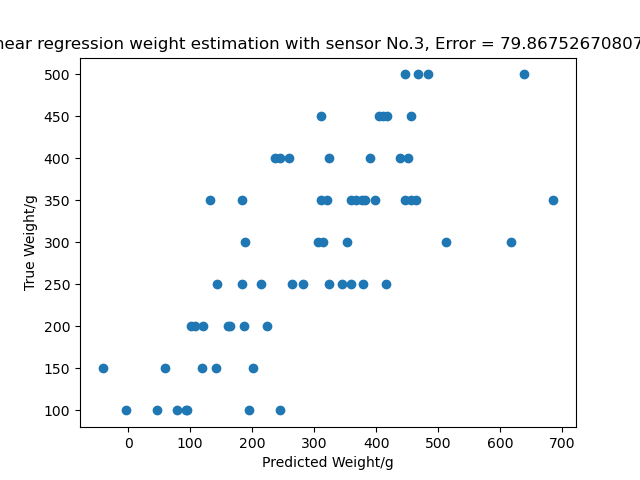

In [58]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.title(f"Linear regression weight estimation with sensor No.{sensor_num}, Error = {mae}")
plt.xlabel("Predicted Weight/g")
plt.ylabel("True Weight/g")
plt.show()

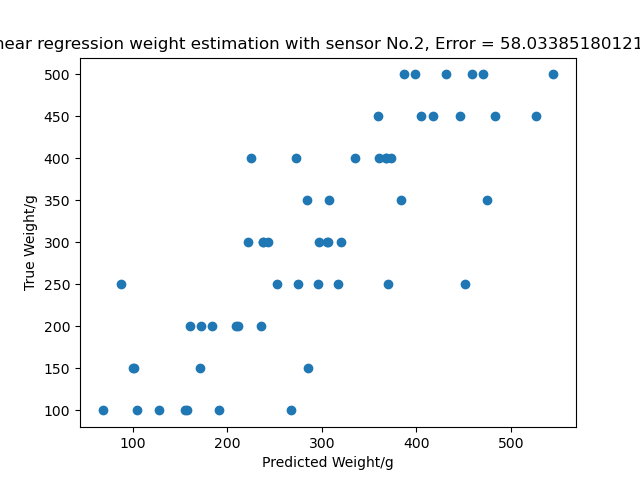

In [13]:
plt.figure()
plt.scatter(y_pred, y_test)
plt.title(f"Linear regression weight estimation with sensor No.{sensor_num}, Error = {mae}")
plt.xlabel("Predicted Weight/g")
plt.ylabel("True Weight/g")
plt.show()

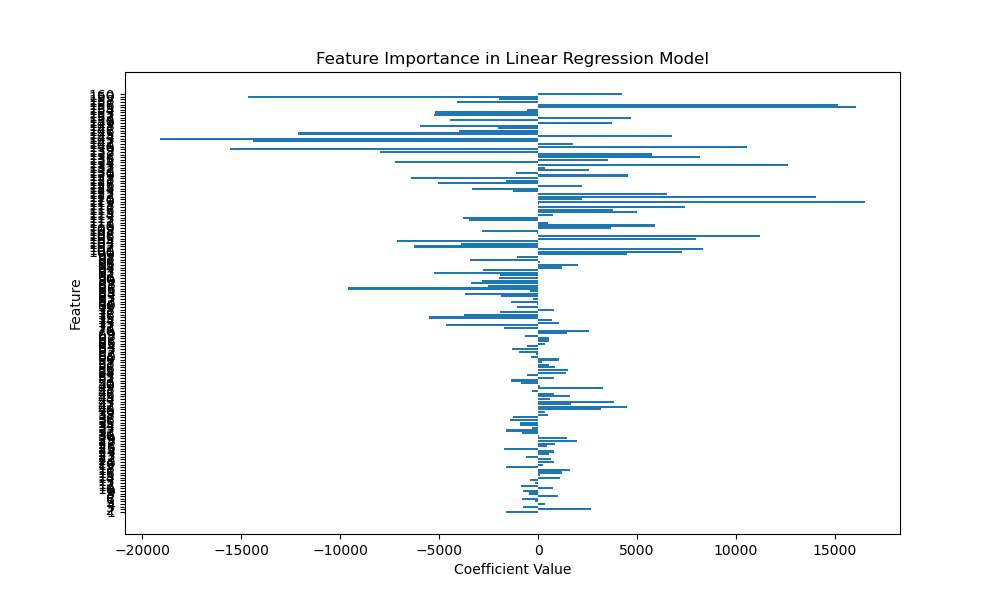

In [68]:
coefficients = model.coef_
if 'feature_names' in locals():
    # Ensure the number of feature names matches the number of coefficients
    assert len(feature_names) == len(coefficients), "Number of feature names and coefficients do not match."
    features = feature_names
else:
    # If no feature names, use generic labels
    features = [f'{i+1}' for i in range(len(coefficients))]

plt.figure(figsize=(10, 6))
plt.barh(features, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression Model')
plt.show()

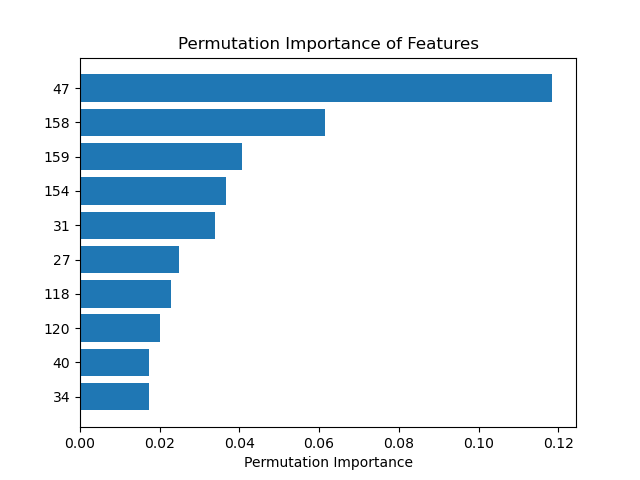

In [80]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
plt.figure()
sorted_idx = perm_importance.importances_mean.argsort()
if 'feature_names' in locals():
    # Ensure the number of feature names matches the number of features in X
    assert len(feature_names) == X.shape[1], "Number of feature names and features in X do not match."
    plt.barh([feature_names[i] for i in sorted_idx[:10]], perm_importance.importances_mean[sorted_idx[:10]])
else:
    plt.barh([f'{i}' for i in sorted_idx[-10:]], perm_importance.importances_mean[sorted_idx[-10:]])

plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.show()

In [99]:
frequency_bins[sorted_idx[-20:]]

array([212.5, 185. , 155. , 375. , 302.5, 347.5, 360. ,  75. ,  87.5,
       152.5,  85. , 100. , 300. , 295. ,  67.5,  77.5, 385. , 397.5,
       395. , 117.5])

In [75]:
sorted_idx

array([ 99,  44,  68,  92,  86,  63,   8, 112,  16,  36,  26, 137,  23,
         5, 123,  69, 126,  50,  19, 114, 109,  45, 107,  10,  83, 146,
        67,  73,  65,  72,  43,  66, 149, 125,  84,  96, 147, 143,  54,
        98,  56, 122,  21, 138,  75,  13, 155,  82, 157,  18, 116,  90,
        20,  41,  78,  64, 153,  60, 127,  48,  97, 106, 129,  29,  95,
         7, 117, 105,  79,  88,  14,  11,  22, 102, 131,  81, 140,   6,
       110, 111, 134,  80,  53,  89,   4, 113, 133, 130,  46, 135,  93,
        87,  55,  25,   2,  57, 124,  49, 145,  24,  51,  77, 119,  38,
       104,  70,   1,   3, 136, 142,  52,  58,   0, 156,   9, 152, 132,
       108,  12, 101,  37, 148,  42,  32,  76,  59,  17,  94,  91, 100,
       128, 141,  15, 103,  39,  71, 115,  28, 151,  33,  85,  74,  62,
       150, 121, 139, 144,  30,  35,  61,  34,  40, 120, 118,  27,  31,
       154, 159, 158,  47])